In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pathlib
from scipy import stats
import numpy as np
import pybedtools
from amb import *
import seaborn  as sns
import joblib

plt.rcParams['pdf.fonttype']=42

In [2]:
hyper_dmr_paths = glob.glob('mC_FILTER_DMR_BED/*.Hyper.aDMR.bed')
hypo_dmr_paths = glob.glob('mC_FILTER_DMR_BED/*.Hypo.aDMR.bed')

In [3]:
use_cts = joblib.load('/home/qzeng/project/aging/metadata/mc_use_cts')
use_cts = [ct.replace(' ','_').replace('/','') for ct in use_cts]

In [4]:
dmr_num = {}
dmr_length = {}
all_celltypes = []
for path in hyper_dmr_paths:
    mt = pathlib.Path(path).name.split('.')[0]
    if mt in use_cts:
        hyper_df = pd.read_csv(path, on_bad_lines='skip', sep = '\t', header = None,index_col = 3)
        hypo_df = pd.read_csv(f"mC_FILTER_DMR_BED/{mt}.Hypo.aDMR.bed", on_bad_lines='skip', sep = '\t', header = None,index_col = 3)

        hyper_df['length'] = hyper_df[2] - hyper_df[1]
        hypo_df['length'] = hypo_df[2] - hypo_df[1]

        hypo_mean = hypo_df['length'].mean()
        hyper_mean = hyper_df['length'].mean()
        mean = (hypo_mean+hyper_mean)/2

        all_celltypes.append(mt)
        dmr_num[mt] = [hyper_df.shape[0]+hypo_df.shape[0] ,hyper_df.shape[0],hypo_df.shape[0]]  
        dmr_length[mt] = [mean]  

In [5]:
dmr_num_df = pd.DataFrame(data = dmr_num, index = ['All aDMRs', 'Aging Hyper','Aging Hypo']).T
dmr_num_df = dmr_num_df.sort_values(by = 'All aDMRs', ascending = False).copy()
#dmr_num_df = dmr_num_df.drop(columns = ['All aDMRs'])
dmr_num_df.head()

,All aDMRs,Aging Hyper,Aging Hypo
OPC_NN,70516,35491,35025
Astro-NT_NN,58742,43960,14782
L23_IT_CTX_Glut,17998,757,17241
Microglia_NN,15929,9447,6482
LDT-PCG-CS_Gata3_Lhx1_Gaba,13622,7935,5687


In [6]:
dmr_length_df = pd.DataFrame(data = dmr_length, index = ['Average Mean']).T
dmr_length_df.head()

,Average Mean
CA1-ProS_Glut,65.319460
CEA-BST_Gaba,63.668145
CA3_Glut,64.369323
DG_Glut,77.458292
MEA-BST_Gaba,65.955874


In [7]:
mc_meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_mC_META.csv', index_col =0)
m3c_meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_m3C_META.csv', index_col =0)

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
meta = pd.concat([mc_meta, m3c_meta], axis =0)

In [9]:
cell_counts = meta['AgingMajorType'].value_counts()

In [10]:
cell_counts.index = cell_counts.index.map(lambda x: x.replace(' ','_').replace('/',''))

In [11]:
toplot = pd.concat([cell_counts, dmr_length_df, dmr_num_df[['All aDMRs']]], axis = 1).dropna()

In [12]:
toplot.columns = ['Cell Number','DMR Length','DMR Number']

In [13]:
toplot.head()

,Cell Number,DMR Length,DMR Number
DG_Glut,17062,77.458292,7192.0
STR_D1_Gaba,15989,77.210276,3579.0
Oligo_NN,15000,96.634623,5028.0
STR_D2_Gaba,12942,72.839573,2875.0
CA1-ProS_Glut,7948,65.319460,1279.0


In [14]:
toplot.sort_values('Cell Number', ascending = False).head(20).index

Index(['DG_Glut', 'STR_D1_Gaba', 'Oligo_NN', 'STR_D2_Gaba', 'CA1-ProS_Glut',
       'Astro-TE_NN', 'L6_CT_CTX_Glut', 'L23_IT_CTX_Glut', 'CA3_Glut',
       'CEA-BST_Gaba', 'L45_IT_CTX_Glut', 'MEA-COA_Glut', 'L6bCT_ENT_Glut',
       'L23_IT_PPP_Glut', 'Microglia_NN', 'STR-PAL_Chst9_Gaba', 'PAG_Glut',
       'LA-BLA-BMA-PA_Glut', 'L23_IT_ENT_Glut', 'L6_IT_CTX_Glut'],
      dtype='object')

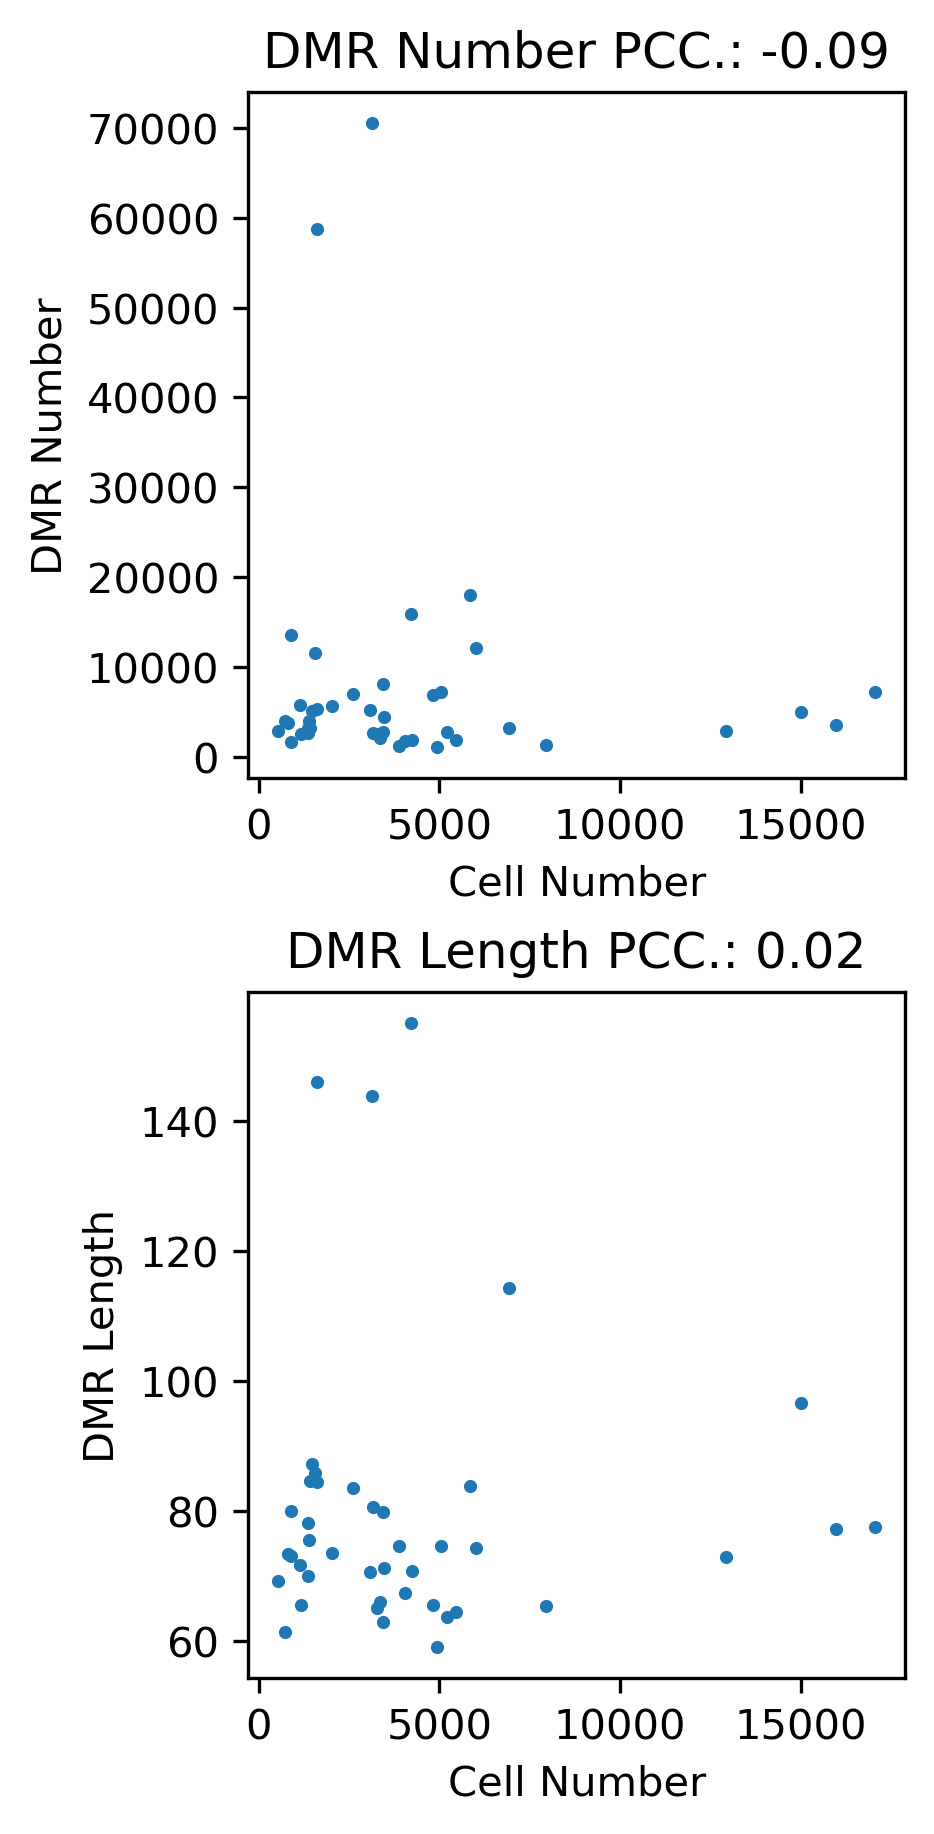

In [16]:
fig, axes= plt.subplots(figsize =(3,6), nrows = 2, dpi = 300,
                        constrained_layout = True)

ax = axes[0]
sns.scatterplot(data = toplot, ax= ax,
                s = 10, linewidth = 0,
                rasterized = True,
                x ='Cell Number',
                y = 'DMR Number')
corr = stats.pearsonr(toplot['Cell Number'], toplot['DMR Number'])[0].round(2)
ax.set_title(f"DMR Number PCC.: {corr}")

ax = axes[1]
sns.scatterplot(data = toplot, ax = ax,
                s = 10, linewidth = 0,
                rasterized = True,
                x ='Cell Number',
                y = 'DMR Length')
corr = stats.pearsonr(toplot['Cell Number'], toplot['DMR Length'])[0].round(2)
ax.set_title(f"DMR Length PCC.: {corr}")
fig.savefig(f"figure/cell_numer_corr.pdf", bbox_inches = 'tight')